In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import spacy


import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from tensorflow import random_normal_initializer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout, Reshape, Activation
import tensorflow.keras as keras
from collections import Counter
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from mlxtend.regressor import StackingCVRegressor

from catboost import CatBoostRegressor
from itertools import product, chain
from tqdm import tqdm
import math  

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
import shap 

import os
import tensorflow as tf
import random 

c:\Users\Prachet.balaji\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_data_path = 'data/train_data.csv'
test_data_path = 'data/test_data.csv'


train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [4]:
train_df.head(-5)


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1,0,N,V,V,U,290.000,1,1960.000,0,1053,0
1,H2037,2015,1,0,V,N,O,R,490.000,1,1850.000,4,1053,0
2,H3802,2014,1,0,N,V,V,U,595.000,1,1960.000,0,1053,0
3,H3834,2013,1,0,V,V,V,U,2840.000,1,1960.000,0,1053,0
4,H5053,2014,1,0,V,N,O,R,680.000,1,1800.000,3,1053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7150,H4637,2014,1,0,V,V,V,U,NaN,2,1962.000,0,23353,0
7151,H48,2014,30136986,0,V,V,V,U,NaN,1,1970.000,0,23353,0
7152,H5016,2012,1,0,V,V,V,U,NaN,2,2001.000,0,23353,1
7153,H5078,2013,1,1,V,V,V,U,NaN,2,1950.000,0,23353,0


In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   int64  
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7160 non-null   int64  
 13  Claim               7160 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 783.3+ KB


In [6]:
train_df.isnull().sum()


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code                0
Claim                   0
dtype: int64

In [7]:
#Dealing with continous variables
train_df.describe().round(2)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code,Claim
count,7160.000,7160.000,7160.000,7054.000,7160.000,6652.000,7160.000,7160.000
mean,2013.670,89404871.230,0.310,1883.730,2.190,1964.460,50215.460,0.230
std,1.380,229129388.170,0.460,2278.160,0.940,36.000,29905.460,0.420
min,2012.000,0.000,0.000,1.000,1.000,1545.000,1053.000,0.000
25%,2012.000,1.000,0.000,528.000,2.000,1960.000,21231.000,0.000
50%,2013.000,1.000,0.000,1083.000,2.000,1970.000,54395.000,0.000
75%,2015.000,1.000,1.000,2289.750,3.000,1980.000,75117.000,0.000
max,2016.000,997260274.000,1.000,20940.000,4.000,2016.000,95607.000,1.000


CHECK DISTRIBUTION OF COLUMNS WITH NULL VALUES FOR IMPUTATION METHOD

<Axes: ylabel='Building Dimension'>

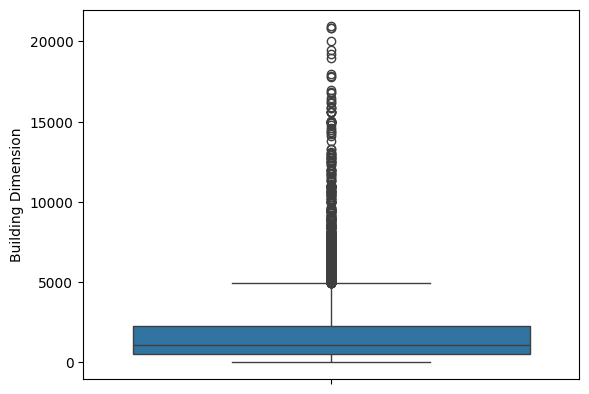

In [8]:
sns.boxplot(train_df['Building Dimension'])

<Axes: ylabel='Date_of_Occupancy'>

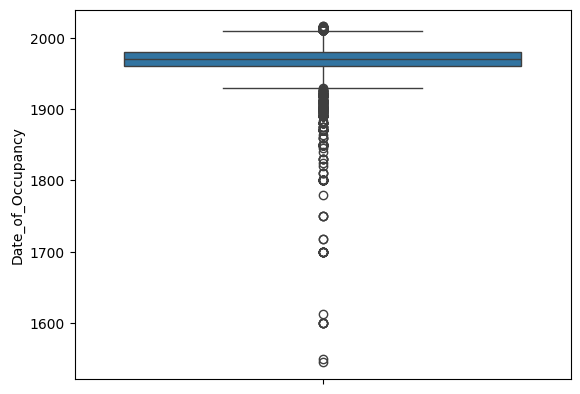

In [9]:
sns.boxplot(train_df['Date_of_Occupancy'])


In [10]:
train_df['Date_of_Occupancy'] = train_df['Date_of_Occupancy'].fillna(train_df['Date_of_Occupancy'].median())
train_df['Building Dimension'] = train_df['Building Dimension'].fillna(train_df['Building Dimension'].median())


In [11]:
train_df['Garden'] = train_df['Garden'].fillna(train_df['Garden'].mode()[0])
train_df['Geo_Code'] = train_df['Geo_Code'].fillna(train_df['Geo_Code'].mode()[0])


In [12]:
train_df.isnull().sum()


Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

DATA ANALYSIS

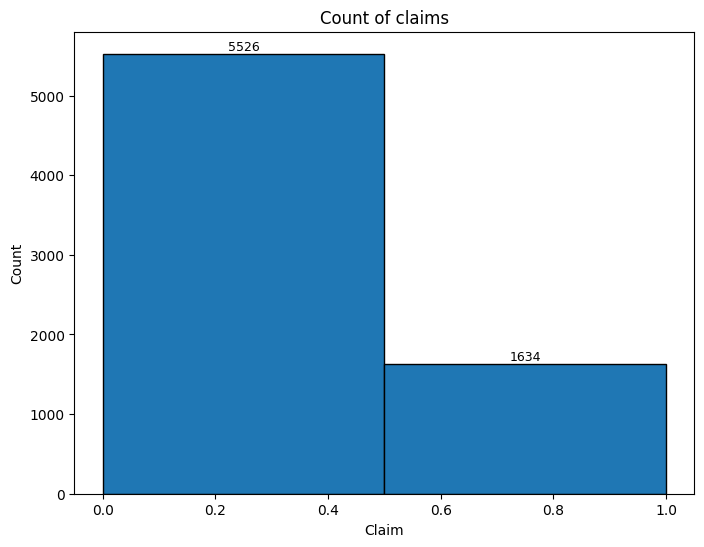

In [20]:

data = train_df['Claim']

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=2, edgecolor='black')

# Annotate each bar with its count
hist_values, bin_edges = np.histogram(data, bins=2)
for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, hist_values[i] + 2,
             str(hist_values[i]), ha='center', va='bottom', fontsize=9)

plt.title('Count of claims')
plt.xlabel('Claim')
plt.ylabel('Count')

plt.show()

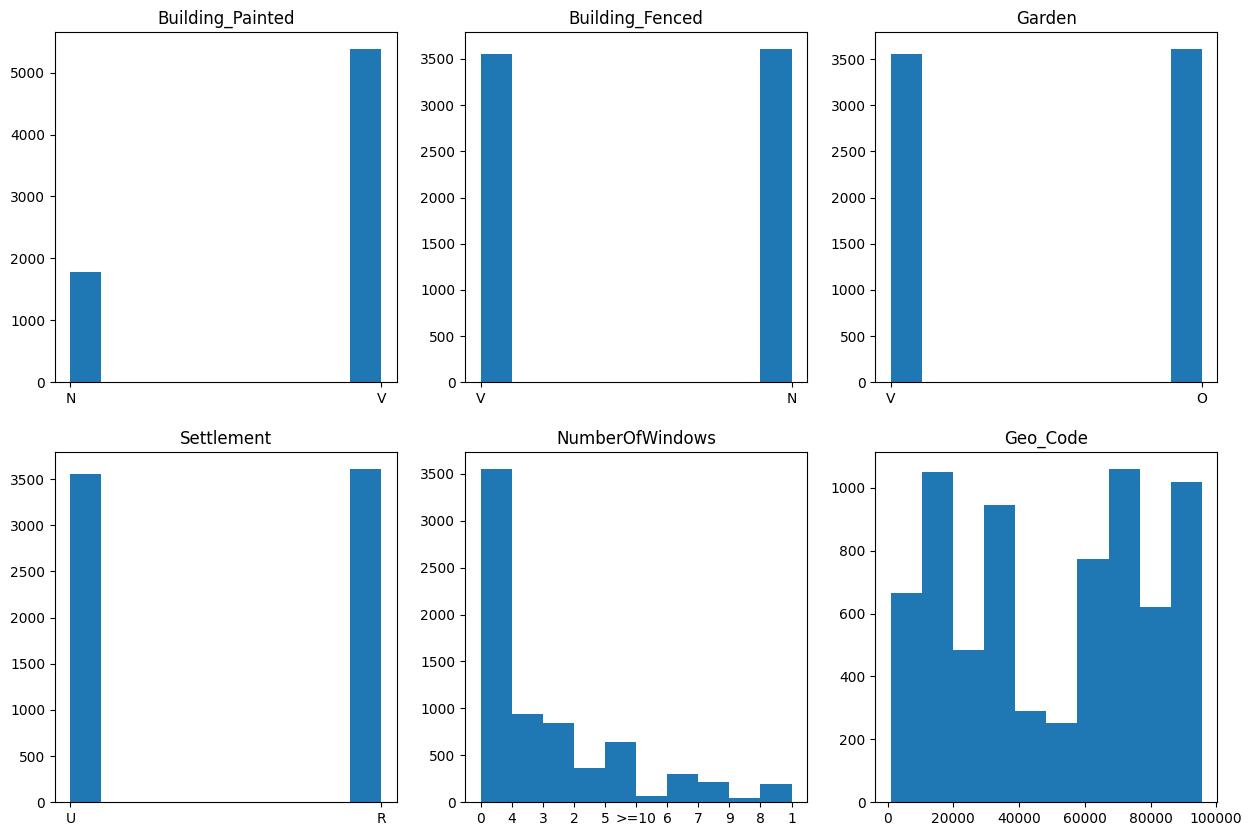

In [39]:
#Categorical Variables
train_cat = ['Building_Painted','Building_Fenced','Garden','Settlement','NumberOfWindows','Geo_Code']

#  plot Numerical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,10))

for i in train_cat:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    #plt.xlabel(i)
    plt.hist(train_df[i])
    c = c + 1

plt.show()

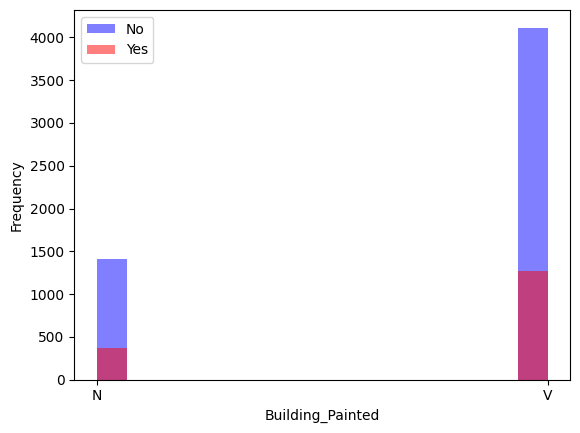

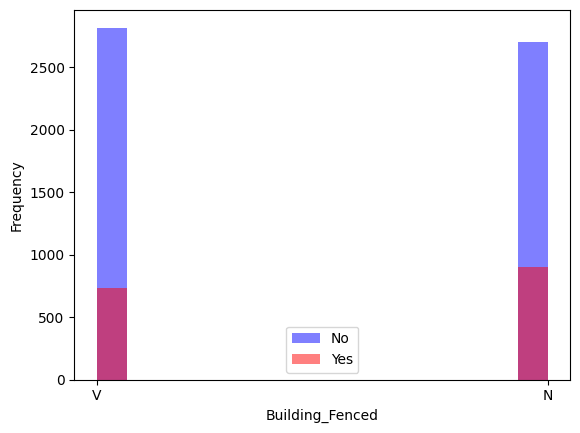

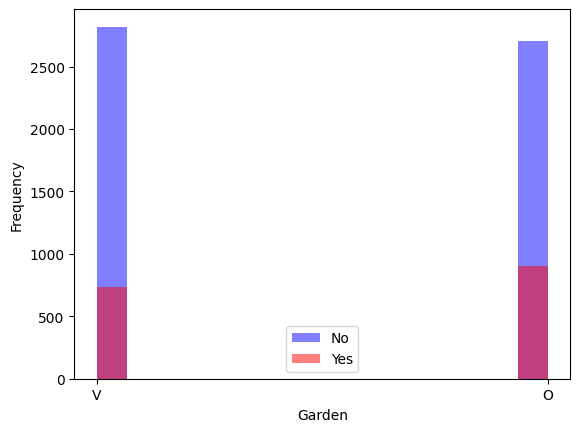

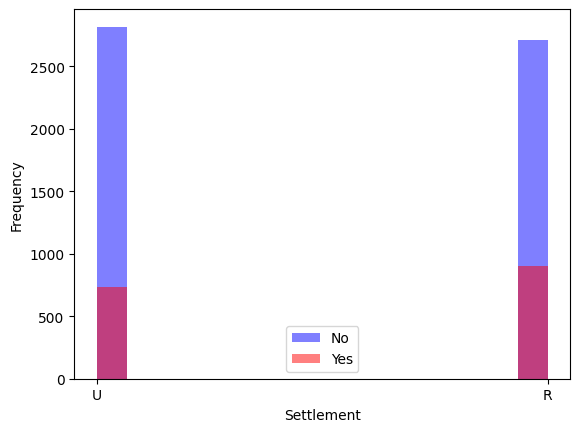

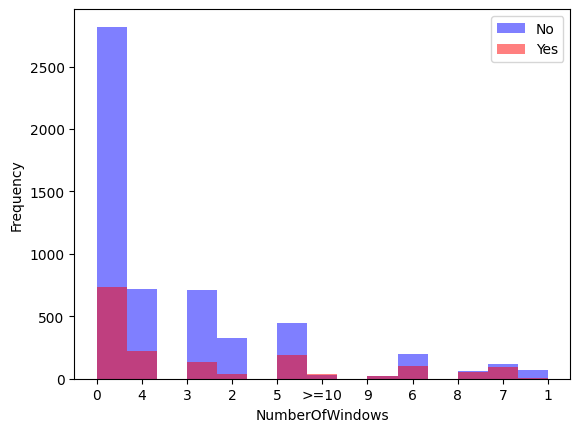

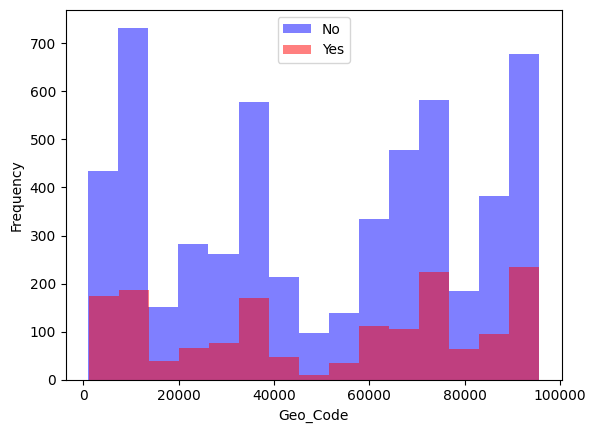

In [70]:
for i in train_cat:
    
    fig, ax = plt.subplots()

    ax.hist(train_df[train_df['Claim']==0][i], bins=15, alpha=0.5, color="blue", label="No")
    ax.hist(train_df[train_df['Claim']==1][i], bins=15, alpha=0.5, color="red", label="Yes")

    ax.set_xlabel(i)
    ax.set_ylabel("Frequency")

    ax.legend()
    

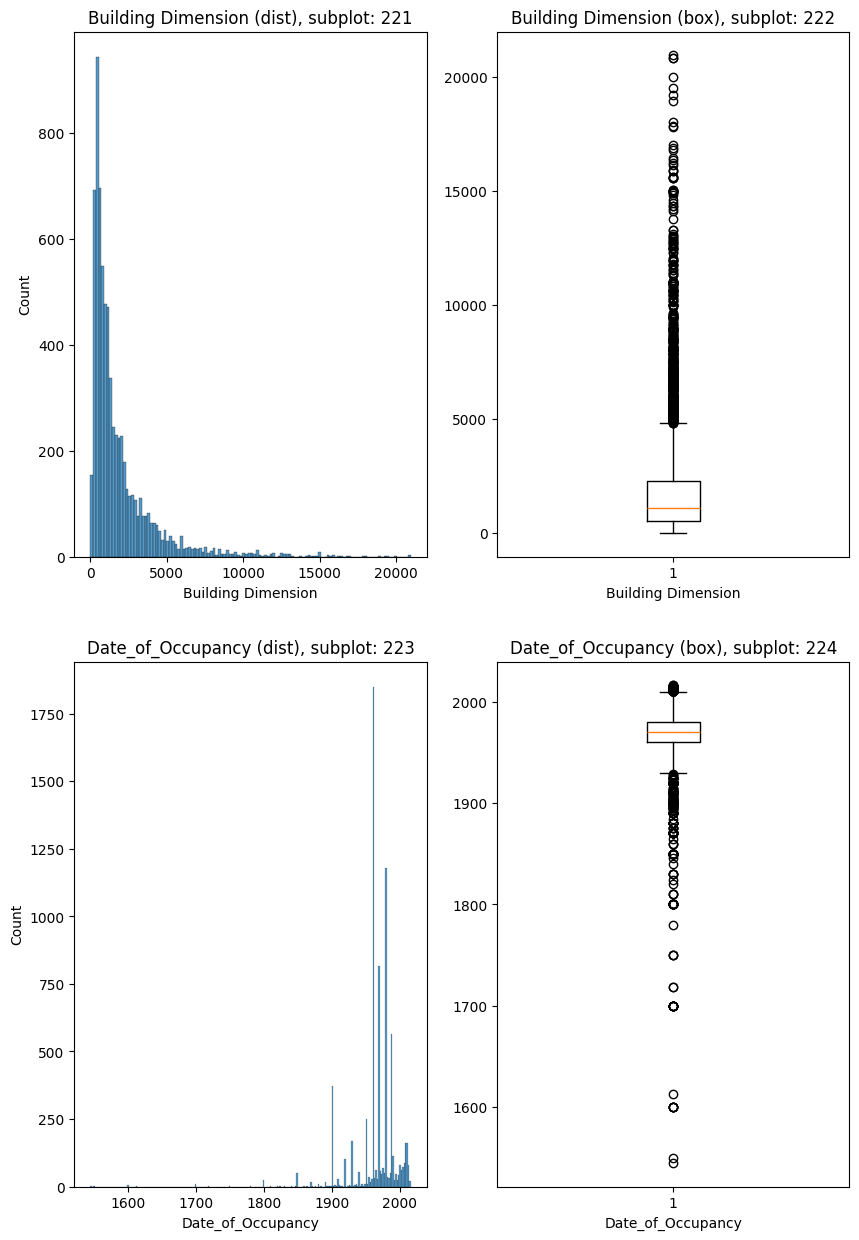

In [69]:
#Numerical Data
train_num = ['Building Dimension', 'Date_of_Occupancy']

#  plot Numerical Data
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,15))

for i in train_num:
    plt.subplot(a, b, c)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.histplot(train_df[i])
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('{} (box), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    plt.boxplot(x = train_df[i])
    c = c + 1

    #plt.subplot(a, b, c)
    #plt.title('{} (scatter), subplot: {}{}{}'.format(i, a, b, c))
    #plt.xlabel(i)
    #sns.scatterplot(data = train_df, x = i, y = 'chol', hue = 'claim')
    #c = c + 1

plt.show()

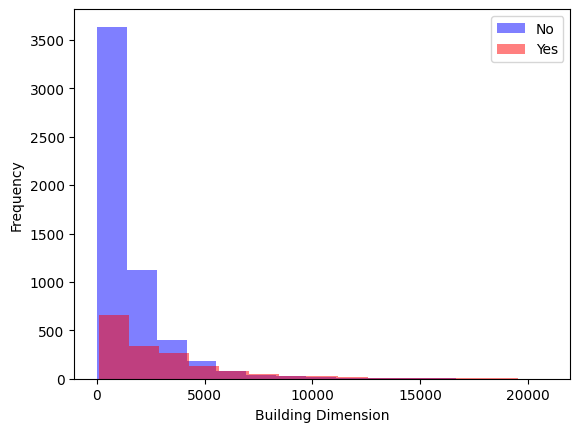

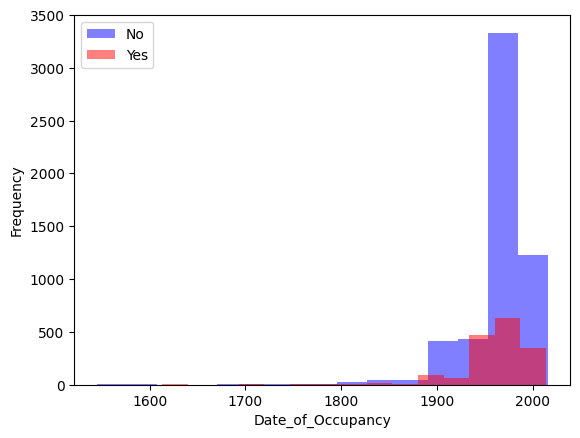

In [72]:
for i in train_num:
    
    fig, ax = plt.subplots()

    ax.hist(train_df[train_df['Claim']==0][i], bins=15, alpha=0.5, color="blue", label="No")
    ax.hist(train_df[train_df['Claim']==1][i], bins=15, alpha=0.5, color="red", label="Yes")

    ax.set_xlabel(i)
    ax.set_ylabel("Frequency")

    ax.legend()
    

FEATURE ENGINEERING

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   int64  
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7160 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7160 non-null   int64  
 13  Claim               7160 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 783.3+ KB


In [76]:
train_df.describe().round()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code,Claim
count,7160.000,7160.000,7160.000,7160.000,7160.000,7160.000,7160.000,7160.000
mean,2014.000,89404871.000,0.000,1872.000,2.000,1965.000,50215.000,0.000
std,1.000,229129388.000,0.000,2263.000,1.000,35.000,29905.000,0.000
min,2012.000,0.000,0.000,1.000,1.000,1545.000,1053.000,0.000
25%,2012.000,1.000,0.000,532.000,2.000,1960.000,21231.000,0.000
50%,2013.000,1.000,0.000,1083.000,2.000,1970.000,54395.000,0.000
75%,2015.000,1.000,1.000,2250.000,3.000,1980.000,75117.000,0.000
max,2016.000,997260274.000,1.000,20940.000,4.000,2016.000,95607.000,1.000
